In [1]:
!pip install tensorflow==2.10.1

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.6 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 74.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 64.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 73.2 MB/s eta 0:00:00:00:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 39.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 60.9 MB/s eta 0:00:00ta 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 50.2 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.12.0
    Uninstalling keras-2.12.0:
      Successfully uninstalled keras-2.12.0
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.12.0
    Uninstalling tensorflow-estimator-2.12.0:
      Successfully uninstal

In [2]:
import os
import re
import cv2
import random
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import imageio as imageio
from glob import glob
from tqdm import tqdm
from keras.utils import plot_model
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, Input, UpSampling2D, AveragePooling2D, MaxPool2D, MaxPooling2D, Concatenate, LeakyReLU, concatenate, Dropout, ReLU, Activation, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
2023-07-31 10:20:39.719512: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl5mutexC1Ev']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-package

In [3]:
WIDTH, HEIGHT = 256, 256
BATCH_SIZE = 16
lr = 1e-04
epochs = 100
image_size = [256,256]

In [35]:
model_path = "/kaggle/working/attn-unet_carlo.h5"
csv_path = "/kaggle/working/csvlogger.csv"

# Helping funtions

In [5]:
#create folder for save augmented images
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [6]:
#get data
def read_data(path):
    images = sorted(glob(os.path.join(path, "CameraRGB/*")))
    masks = sorted(glob(os.path.join(path, "CameraSeg/*")))
    
    return images, masks

In [7]:
def show_images_with_masks(image_dir, mask_dir):
    #image_files = sorted(os.listdir(image_dir))
    #mask_files = sorted(os.listdir(mask_dir))

    # Ensure equal number of images and masks
    num_files = min(len(image_dir), len(image_dir))

    # Display 5 images and masks
    num_display = min(num_files, 5)
    fig, axs = plt.subplots(num_display, 2, figsize=(10, 10))

    for i in range(num_display):

        image = cv2.imread(image_dir[i])
        mask = cv2.imread(mask_dir[i])[:,:,2]

        # Display image
        axs[i, 0].imshow(image)
        axs[i, 0].axis('off')
        axs[i, 0].set_title('Image')

        # Display mask
        axs[i, 1].imshow(mask)
        axs[i, 1].axis('off')
        axs[i, 1].set_title('Mask')

    plt.tight_layout()
    plt.show()

In [8]:
class DataGenerator(tf.keras.utils.Sequence):
    def __init__(self, img_filenames,
                 mask_filenames,
                 batch_size=BATCH_SIZE,
                 shuffle=True):

        self.img_filenames = img_filenames
        self.mask_filenames = mask_filenames
        self.filenames = list(zip(img_filenames, mask_filenames))
        self.batch_size = BATCH_SIZE
        self.shuffle= shuffle
        self.n = len(self.img_filenames)

    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)

    def __get_data(self, batches):
        imgs=[]
        segs=[]
        for img_file, mask_file in batches:
            image = cv2.imread(img_file)
            image = cv2.resize(image, (WIDTH, HEIGHT))
            image = image / 255.
            
            mask = cv2.imread(mask_file)
            mask = cv2.resize(mask, (WIDTH, HEIGHT))[:, :, 2]

            imgs.append(image)
            segs.append(mask)

        return np.array(imgs), np.array(segs)
    
    def __getitem__(self, index):

        batches = self.filenames[index * self.batch_size:(index + 1) * self.batch_size]

        X, y = self.__get_data(batches)

        return (X, y)

    def __len__(self):

        return self.n // self.batch_size

In [9]:
#set color to image
def give_color_to_seg_img(seg, n_classes=13):
    seg_img = np.zeros( (seg.shape[0],seg.shape[1], 3) ).astype('float')
    colors = sns.color_palette("hls", n_classes)
    
    for c in range(n_classes):
        segc = (seg == c)
        seg_img[:,:,0] += (segc*( colors[c][0] ))
        seg_img[:,:,1] += (segc*( colors[c][1] ))
        seg_img[:,:,2] += (segc*( colors[c][2] ))

    return(seg_img)

# Data Preprocessing

In [10]:
path_1 = "/kaggle/input/lyft-udacity-challenge/dataA/dataA"
path_2 = "/kaggle/input/lyft-udacity-challenge/dataB/dataB"
path_3 = "/kaggle/input/lyft-udacity-challenge/dataC/dataC"
images_1, masks_1 = read_data(path_1)
images_2, masks_2 = read_data(path_2)
images_3, masks_3 = read_data(path_3)

In [11]:
test_path = "/kaggle/input/lyft-udacity-challenge/dataD/dataD"
test_images, test_masks = read_data(test_path)

In [12]:
images = images_1 + images_2 + images_3
masks = masks_1 + masks_2 + masks_3

In [13]:
len(images), len(masks)

(3000, 3000)

In [14]:
train_gen = DataGenerator(images, masks)
test_gen = DataGenerator(test_images, test_masks)

In [15]:
#train data shape
for x, y in train_gen:
    break
x.shape, y.shape

((16, 256, 256, 3), (16, 256, 256))

In [16]:
#test data shape
for x, y in test_gen:
    break
x.shape, y.shape

((16, 256, 256, 3), (16, 256, 256))

(-0.5, 255.5, 255.5, -0.5)

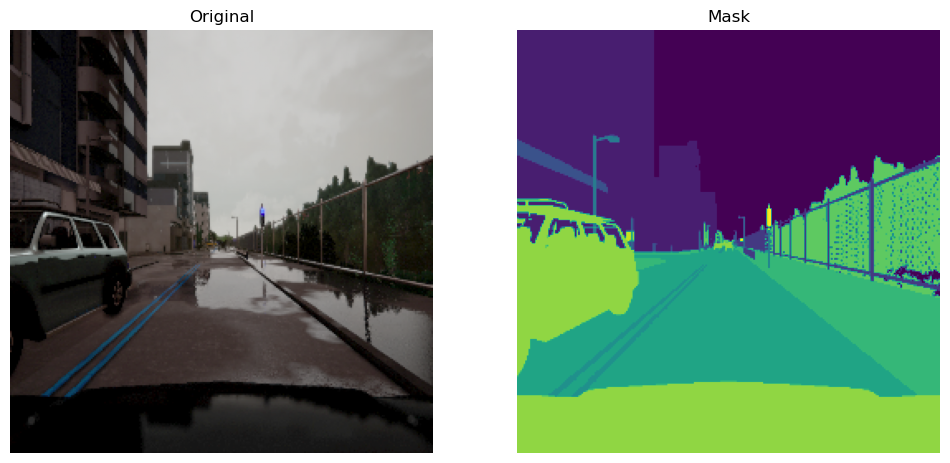

In [17]:
#visualize image and mask
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(x[0])
plt.title('Original')
plt.axis('off')

plt.subplot(122)
plt.imshow(y[0])
plt.title('Mask')
plt.axis('off')

# Model - Attention U-Net

In [18]:
def conv_block(x, num_filters):
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    x = Conv2D(num_filters, 3, padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    
    return x

In [19]:
def attention_layer(g, s, num_filters):
    wg = Conv2D(num_filters, 1, padding='same')(g)
    wg = BatchNormalization()(wg)
    
    ws = Conv2D(num_filters, 1, padding='same')(s)
    ws = BatchNormalization()(ws)
    
    out = Activation('relu')(wg + ws)
    out = Conv2D(num_filters, 1, padding='same')(out)
    out = Activation('sigmoid')(out)
    
    return out * s

In [20]:
def encoder_block(x, num_filters):
    x = conv_block(x, num_filters)
    p = MaxPool2D((2,2))(x)
    return x, p

In [21]:
def decoder_block(x, s, num_filters):
    x = UpSampling2D(interpolation='bilinear')(x)
    s = attention_layer(x, s, num_filters)
    x = Concatenate()([x,s])
    x = conv_block(x, num_filters)
    return x

In [22]:
def attention_unet(input_shape):
    inputs = Input(input_shape)
    
    s1, p1 = encoder_block(inputs, 64)
    s2, p2 = encoder_block(p1, 128)
    s3, p3 = encoder_block(p2, 256)
    
    b1 = conv_block(p3, 512)
    
    d1 = decoder_block(b1, s3, 256)
    d2 = decoder_block(d1, s2, 128)
    d3 = decoder_block(d2, s1, 64)
    
    outputs = Conv2D(13, 1, padding='same', activation='softmax')(d3)
    model = Model(inputs, outputs, name='Attn-Unet')
    
    return model

In [23]:
inputs = (256, 256, 3)
model = attention_unet(inputs)
model.summary()

Model: "Attn-Unet"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 256, 256, 64  256        ['conv2d[0][0]']                 
 alization)                     )                                                         

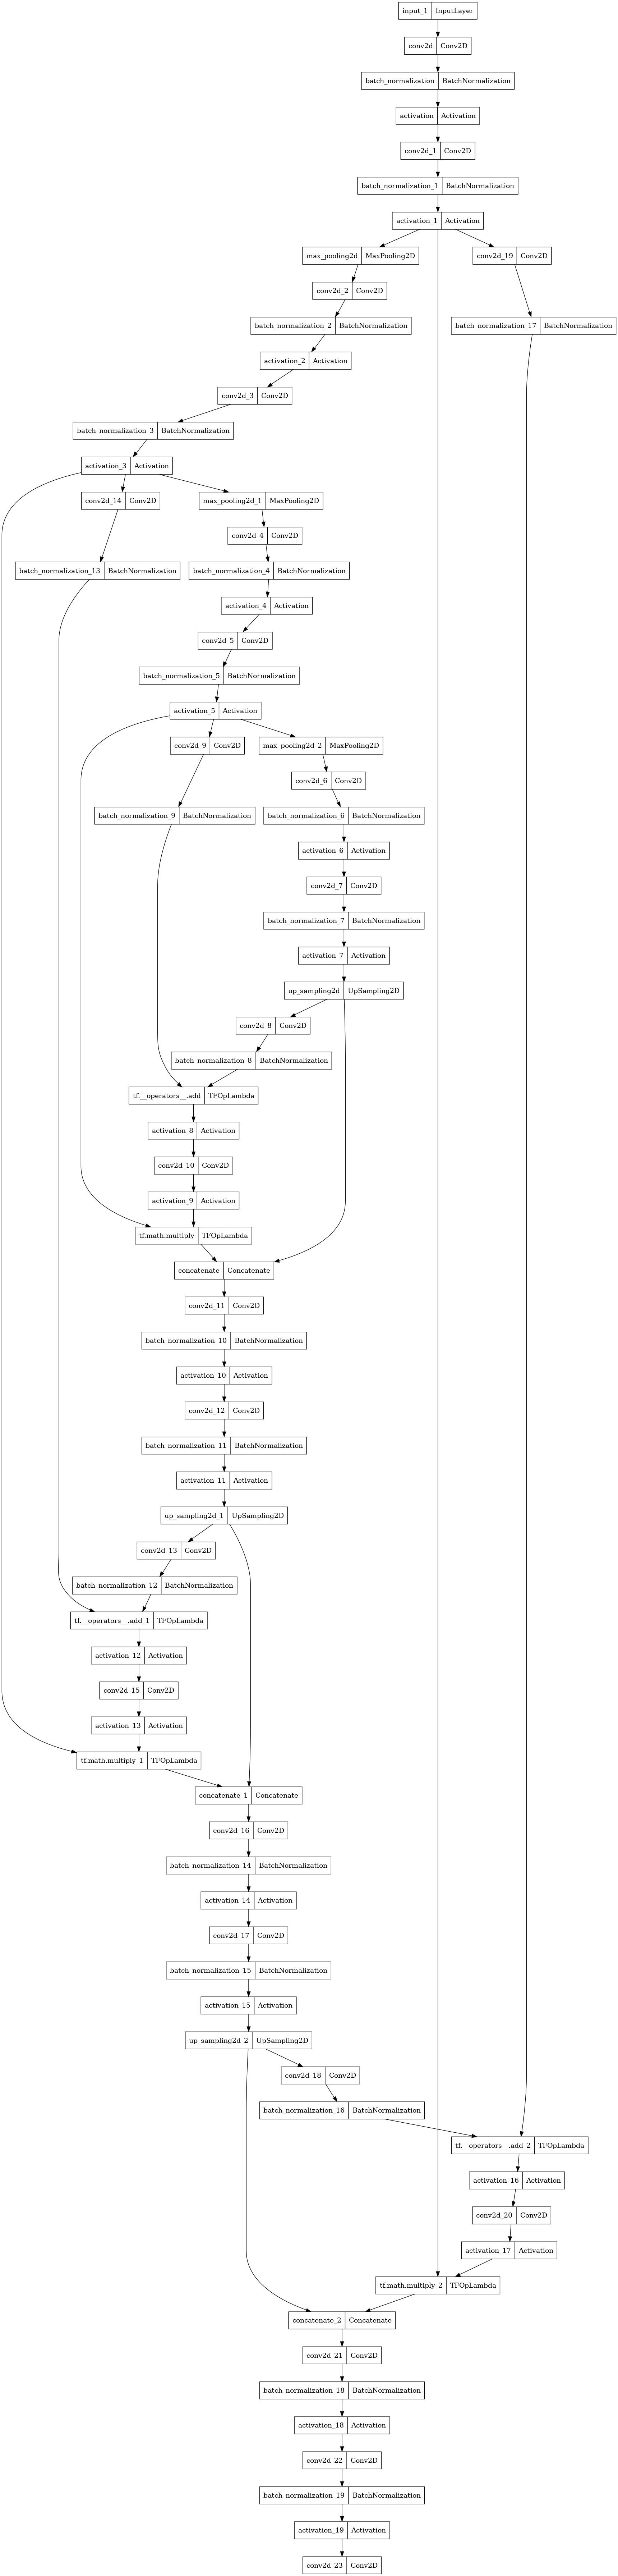

In [24]:
plot_model(model, '/kaggle/working/attn-unet.png')

In [25]:
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(lr), metrics=['accuracy'])

In [26]:
#Callbacks
Callbacks = [
    ModelCheckpoint(model_path, verbose=1, save_best_only=True), 
    CSVLogger(csv_path),
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, min_lr=1e-7, verbose=1)
]

# Training

In [30]:
train_steps = len(train_gen)
val_steps = len(test_gen)

history = model.fit(train_gen, validation_data=test_gen, 
                    steps_per_epoch=train_steps, validation_steps=val_steps, 
                    epochs = 10, verbose=1, callbacks=Callbacks)

Epoch 1/10
187/187 [==============================] - ETA: 0s - loss: 0.1472 - accuracy: 0.9566
Epoch 1: val_loss did not improve from 0.14412
187/187 [==============================] - 223s 1s/step - loss: 0.1472 - accuracy: 0.9566 - val_loss: 0.1453 - val_accuracy: 0.9571 - lr: 1.0000e-04
Epoch 2/10
187/187 [==============================] - ETA: 0s - loss: 0.1269 - accuracy: 0.9621
Epoch 2: val_loss improved from 0.14412 to 0.13778, saving model to /kaggle/working/deeplabv3_carlo.h5
187/187 [==============================] - 222s 1s/step - loss: 0.1269 - accuracy: 0.9621 - val_loss: 0.1378 - val_accuracy: 0.9590 - lr: 1.0000e-04
Epoch 3/10
187/187 [==============================] - ETA: 0s - loss: 0.1222 - accuracy: 0.9633
Epoch 3: val_loss improved from 0.13778 to 0.13309, saving model to /kaggle/working/deeplabv3_carlo.h5
187/187 [==============================] - 222s 1s/step - loss: 0.1222 - accuracy: 0.9633 - val_loss: 0.1331 - val_accuracy: 0.9603 - lr: 1.0000e-04
Epoch 4/10
1

# Performance of Model

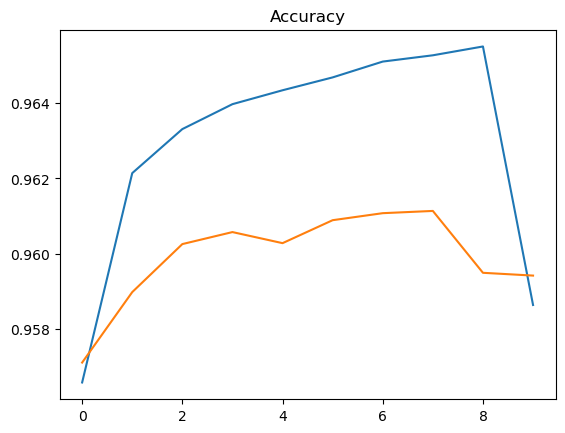

In [31]:
plt.figure()
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title("Accuracy")
plt.show()

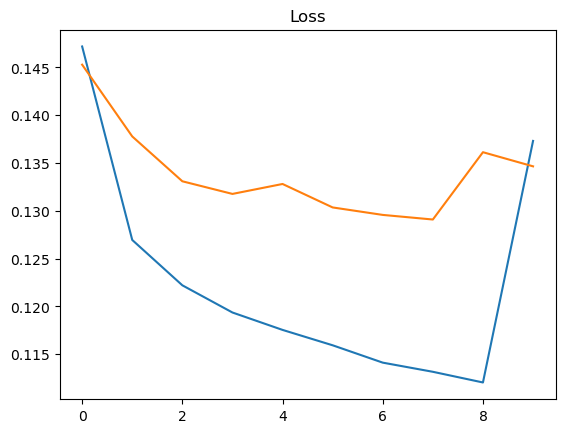

In [32]:
plt.figure()
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title("Loss")
plt.show()

# Prediction and Visualization

In [33]:
create_dir("/kaggle/working/predicted")

1/1 [==============================] - 0s 457ms/step


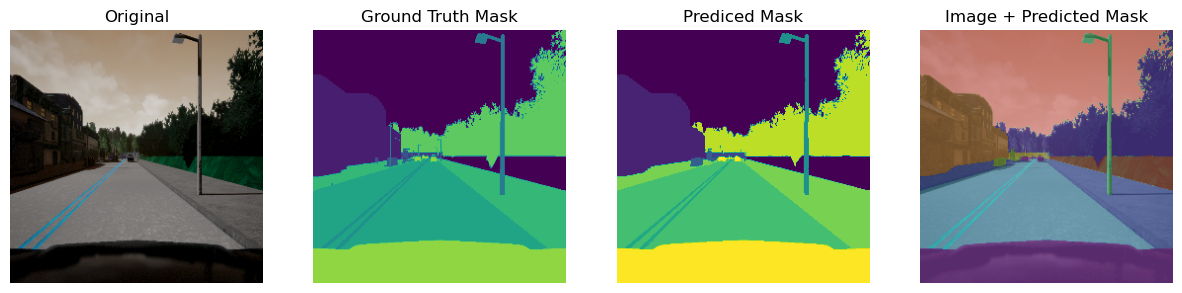

1/1 [==============================] - 0s 46ms/step


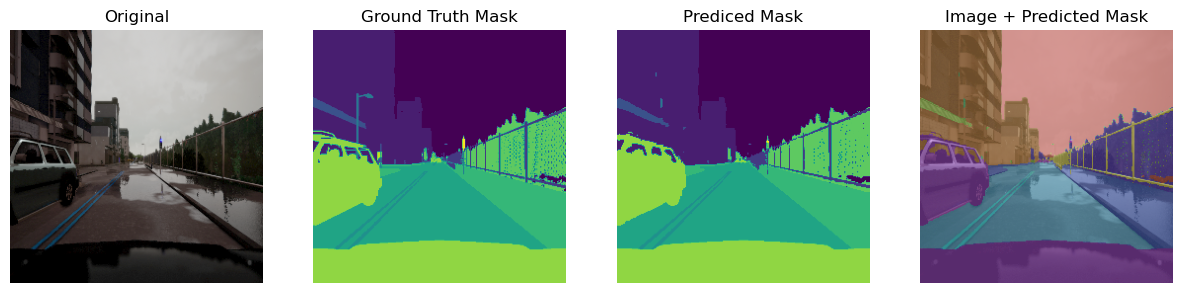

1/1 [==============================] - 0s 34ms/step


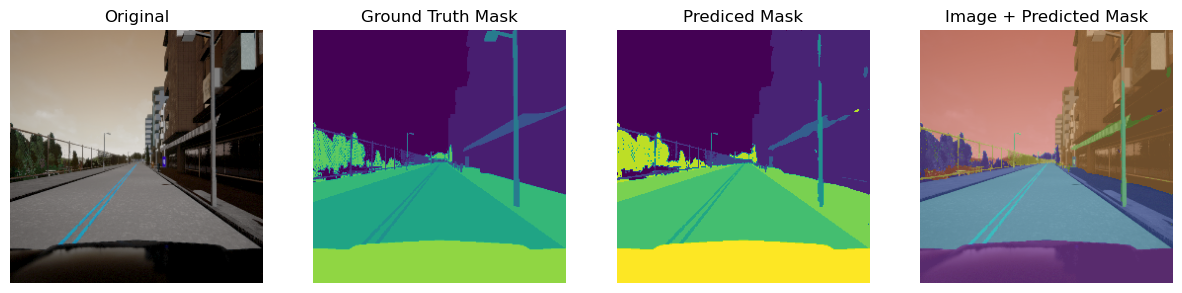

1/1 [==============================] - 0s 32ms/step


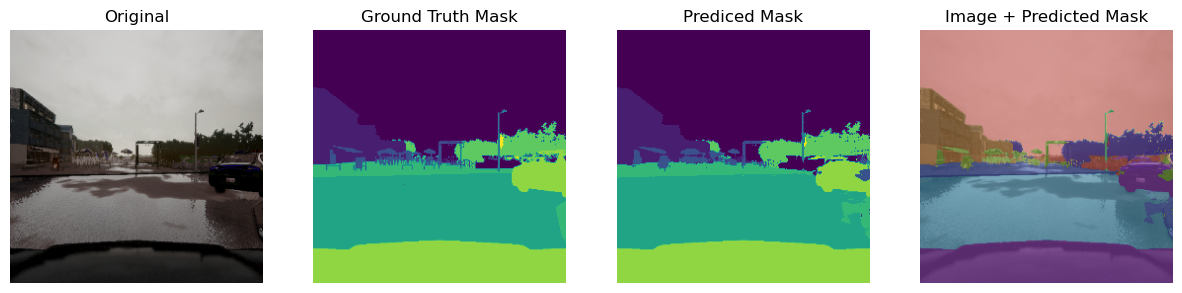

1/1 [==============================] - 0s 32ms/step


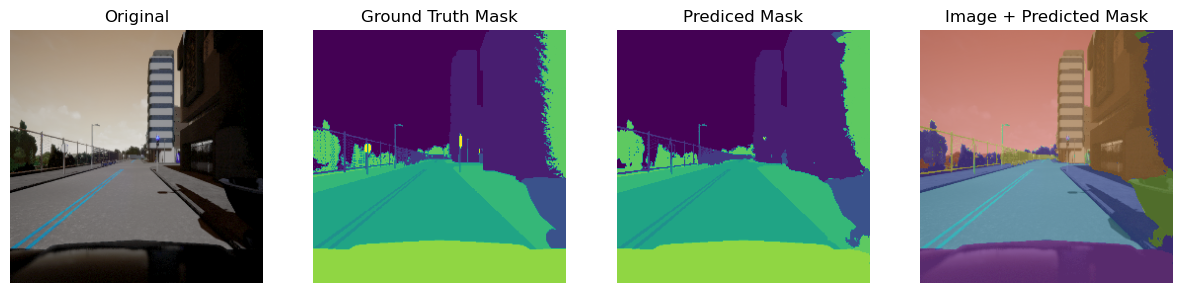

1/1 [==============================] - 0s 31ms/step


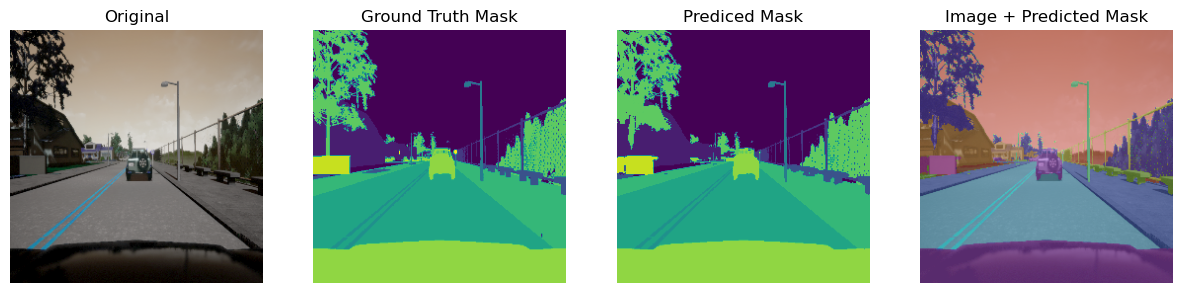

1/1 [==============================] - 0s 31ms/step


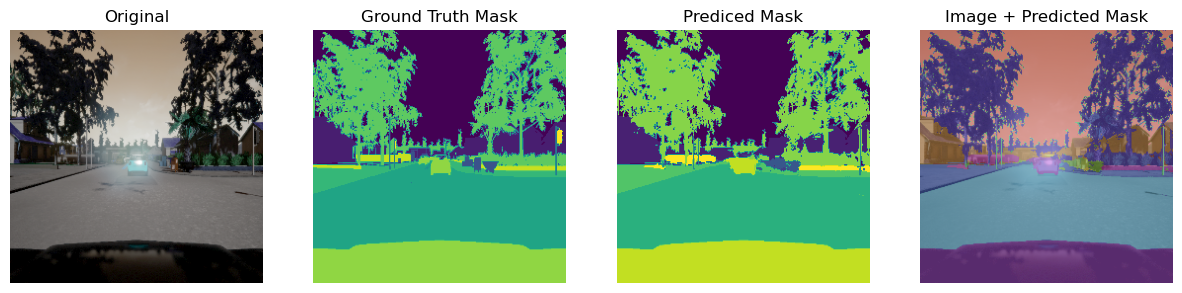

1/1 [==============================] - 0s 31ms/step


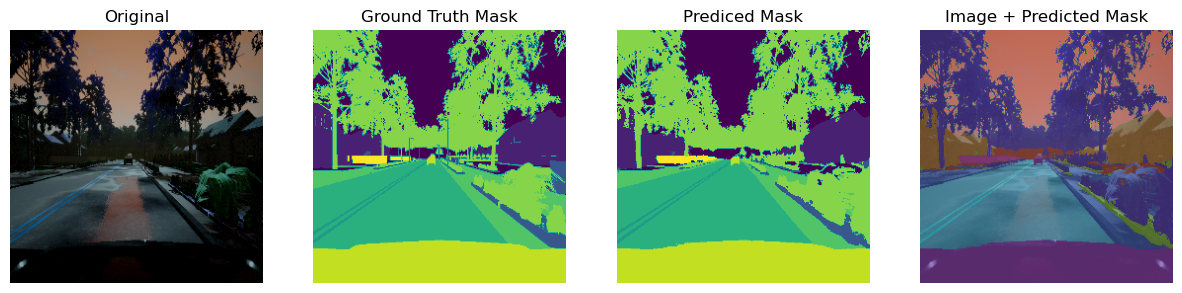

1/1 [==============================] - 0s 32ms/step


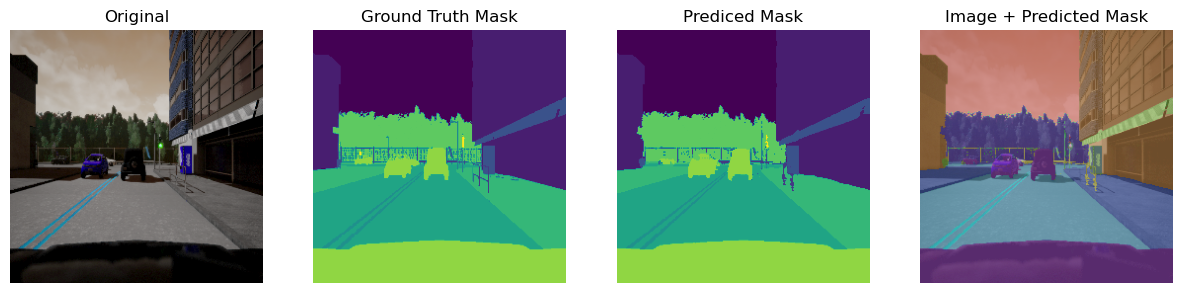

1/1 [==============================] - 0s 31ms/step


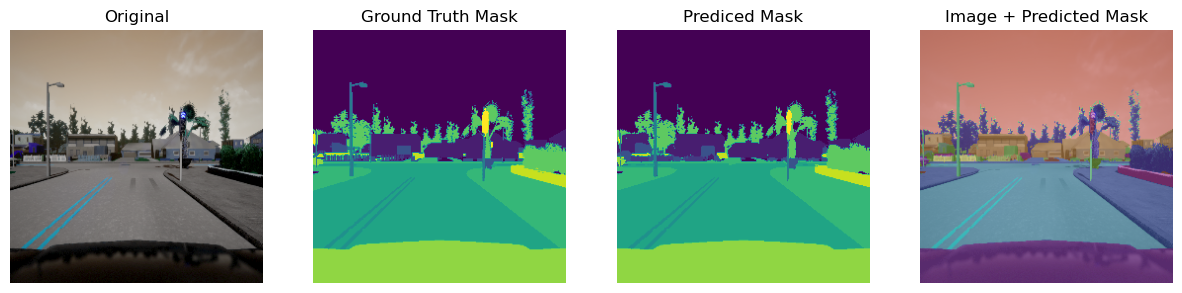

1/1 [==============================] - 0s 33ms/step


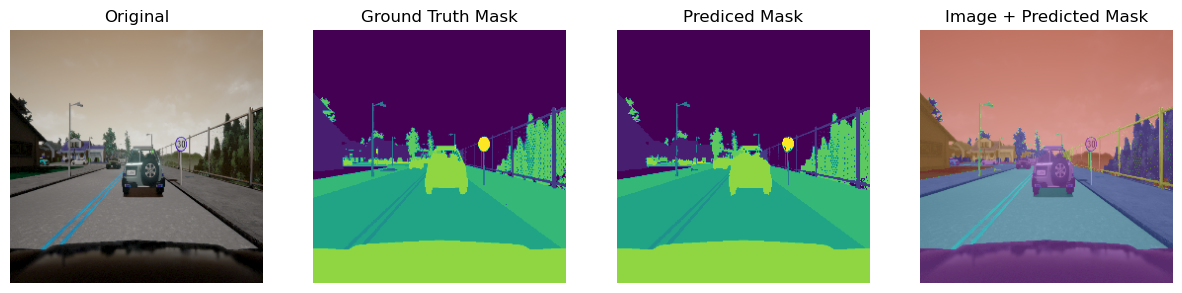

1/1 [==============================] - 0s 33ms/step


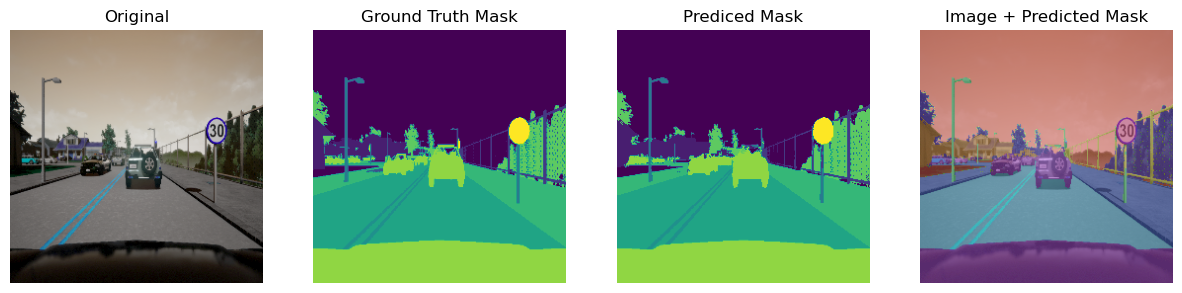

In [34]:
#prediction
max_show = 12
test_iter = iter(test_gen)
for i in range(max_show):
    images, masks = next(test_iter)
    mask_color = give_color_to_seg_img(masks[0])

    preds = model.predict(images)
    pred_masks = np.argmax(preds, axis = 3)
    pred_mask_color = give_color_to_seg_img(pred_masks[0])
    fig, ax = plt.subplots(1, 4, figsize=(15, 6))
    
    for a in ax:
        a.axis('off')

    ax[0].imshow(images[0])
    ax[0].set_title('Original')
    
    ax[1].imshow(masks[0])
    ax[1].set_title('Ground Truth Mask')
    
    ax[2].imshow(pred_masks[0])
    ax[2].set_title('Prediced Mask')
    
    ax[3].imshow(images[0] * 0.5 + pred_mask_color * 0.5)
    ax[3].set_title('Image + Predicted Mask')
    plt.savefig(f"predicted/pred_{i}.jpg", dpi=150)
    plt.show()

In [36]:
model.save(model_path)